# IMDB 영화 리뷰 감성 분류

## 1. IMDB 리뷰 데이터에 대한 이해

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras.datasets import imdb

In [2]:
# 훈련 데이터와 테스트 데이터를 50:50 비율로 구분해서 제공
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=None)

In [3]:
len(X_train), len(X_test)

(25000, 25000)

In [4]:
# 긍정: 1, 부정: 0
print('카테고리 : {}'.format(max(y_train) + 1))

카테고리 : 2


In [5]:
for i in range(10):
    print(len(X_train[i]))

218
189
141
550
147
43
123
562
233
130


In [6]:
# 일곱번째 데이터 확인
print(X_train[6])
print(y_train[6])

[1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 10626, 5940, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 16393, 9363, 1117, 1831, 7485, 5, 4831, 26, 6, 71690, 4183, 17, 369, 37, 215, 1345, 143, 32677, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 26441, 8564, 63, 271, 6, 196, 96, 949, 4121, 4, 74170, 7, 4, 2212, 2436, 819, 63, 47, 77, 7175, 180, 6, 227, 11, 94, 2494, 33740, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 5390, 99, 76, 23, 77842, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
1


In [7]:
# 리뷰의 길이 분포
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


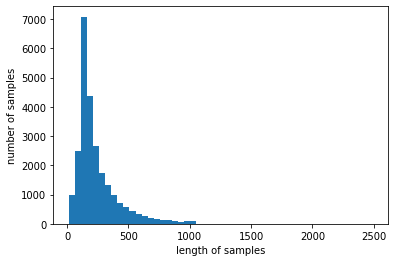

In [8]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
# 레이블의 분포
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


In [10]:
# X_train에 들어있는 숫자들이 각자 어떤 단어들을 나타내고 있는지 확인
word_to_index = imdb.get_word_index()
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value] = key
len(word_to_index)

88584

In [11]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 12345번 단어 : {}'.format(index_to_word[12345]))
print('빈도수 최하위(88584) 단어 : {}'.format(index_to_word[88584]))

빈도수 상위 1번 단어 : the
빈도수 상위 12345번 단어 : liberated
빈도수 최하위(88584) 단어 : 'l'


In [12]:
# 일곱번째 리뷰 복원
print(' '.join([index_to_word[s] for s in X_train[6]]))

the boiled full involving to impressive boring this as murdering naschy br villain council suggestion need has of costumes b message to may of props this echoed concentrates concept issue skeptical to god's he is dedications unfolds movie women like isn't surely i'm rocketed to toward in here's for from did having because very quality it is captain's starship really book is both too worked carl of mayfair br of reviewer closer figure really there will originals things is far this make mistakes kevin's was couldn't of few br of you to don't female than place she to was between that nothing dose movies get are 498 br yes female just its because many br of overly to descent people time very bland


## 2. LSTM으로 IMDB 리뷰 감성 분류
- 모든 단어가 아닌 빈도수 5000 까지
- 모든 문장이 아니라 500 단어까지

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
# 등장 빈도가 5,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

In [15]:
# 모델의 입력으로 사용하는 모든 리뷰의 길이를 동일하게 500으로 맞춤
max_len=500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [16]:
# LSTM 모델
model = Sequential()
model.add(Embedding(5000, 120))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         600000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 715,801
Trainable params: 715,801
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 모델의 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath = "model/imdb-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5,
                    batch_size=64, callbacks=[checkpointer])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.7987
Epoch 00001: val_loss improved from inf to 0.36659, saving model to model/imdb-01-0.3666.hdf5
25000/25000 [==============================] - 123s 5ms/sample - loss: 0.4350 - accuracy: 0.7989 - val_loss: 0.3666 - val_accuracy: 0.8470
Epoch 2/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.3051 - accuracy: 0.8782
Epoch 00002: val_loss did not improve from 0.36659
25000/25000 [==============================] - 198s 8ms/sample - loss: 0.3050 - accuracy: 0.8782 - val_loss: 0.4117 - val_accuracy: 0.8553
Epoch 3/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.2459 - accuracy: 0.9048
Epoch 00003: val_loss improved from 0.36659 to 0.31798, saving model to model/imdb-03-0.3180.hdf5
25000/25000 [==============================] - 145s 6ms/sample - loss: 0.2460 - accuracy: 0.9048 - val_loss: 0.3180 - val_accuracy: 

In [20]:
# Best Model 선택
from tensorflow.keras.models import load_model
del model
model = load_model('model/imdb-03-0.3180.hdf5')

In [21]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, verbose=2)[1]))

25000/1 - 71s - loss: 0.3948 - accuracy: 0.8709

 테스트 정확도: 0.8709


In [22]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

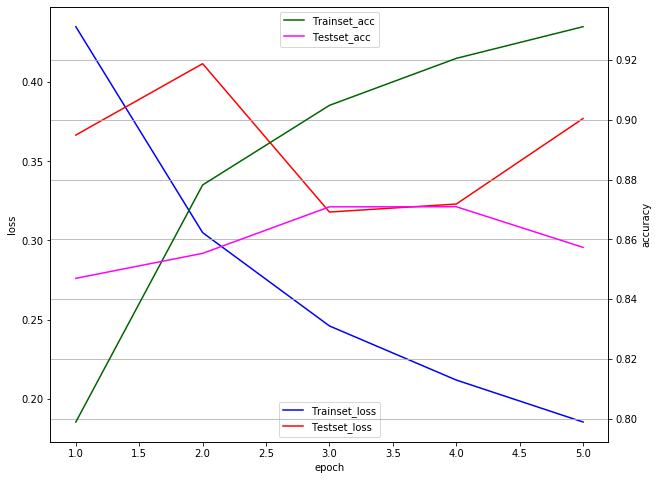

In [23]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()